### Imports

In [45]:
import scipy.io
from scipy import signal
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from sklearn.decomposition import PCA
import seaborn as sb
import h5py

### Utils

In [97]:
def load_mat_v73(file_path):
    data = {}
    with h5py.File(file_path, 'r') as file:
        print(file.keys())
        data['traces'] = file['C_df_ave'][()]
        data['traces_denoised'] = file['C_df_dec'][()]
        data['spikes'] = file['S_dec'][()].T
        data['time'] = file['time'][()].flatten()
        data['frate'] = file['frate'][()].flatten()
        return data
    
    
def compute_pairwise_correlations(data):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    n_neurons = data.shape[0]
    correlations = []
    for i in range(n_neurons):
        print(str(i)+'/'+str(n_neurons))
        for j in range(i+1, n_neurons):
            corr, p_value = pearsonr(data[i, :], data[j, :])
            correlations.append(corr)

    return correlations


def average_spikes(data, window):
    """
    Averages the spike values within specified time windows.

    Parameters:
    - data: dict, containing 'time' and 'spikes' keys with arrays as their values.
    - window: float, the time window in the same units as data['time'] for averaging spikes.

    Returns:
    - A dictionary with 'time' and 'avg_spikes' as keys. 'time' is the center of each time window,
      and 'avg_spikes' contains the average spike magnitude for each window.
    """
    time = np.array(data['time'])
    spikes = np.array(data['spikes'])
    
    result_time = []
    result_avg_spikes = []
    
    start_time = time[0]
    end_time = time[-1]
    
    current_start = start_time
    current_end = current_start + window
    while current_end < end_time:
        current_end = current_start + window
        indices = np.where((time >= current_start) & (time < current_end))[0]
        avg_spike = np.mean(spikes[:, indices], axis=1)
        result_time.append(current_start + window / 2)
        if len(result_avg_spikes) == 0:
            result_avg_spikes = avg_spike
        else:
            result_avg_spikes = np.vstack((result_avg_spikes, avg_spike))
        current_start += window
    
    return {'time': result_time, 'avg_spikes': result_avg_spikes.T}

# Cortex PPC (2p data)

### Import and visualize data

In [54]:
mat_file_path = 'calcium_data/Alipasha/MB48_Hybrid_v2_00004_2pONLY_cnmf_results.mat' 
data = load_mat_v73(mat_file_path)
#print(data)

<KeysViewHDF5 ['#refs#', '#subsystem#', 'A_or', 'C_df', 'C_df_ave', 'C_df_dec', 'F0', 'S_dec', 'bl', 'center', 'frate', 'g', 'neuron_sn', 'options', 'time']>


In [55]:
print('Shapes: ', data['traces'].shape, data['traces_denoised'].shape, data['spikes'].shape, data['time'].shape, data['frate'].shape)

Shapes:  (2268, 8360) (2268, 8360) (2268, 8360) (8360,) (1,)


In [56]:
print('Temporal resolution: ', 1/data['frate'][0], 'sec')

Temporal resolution:  0.07259001161440186 sec


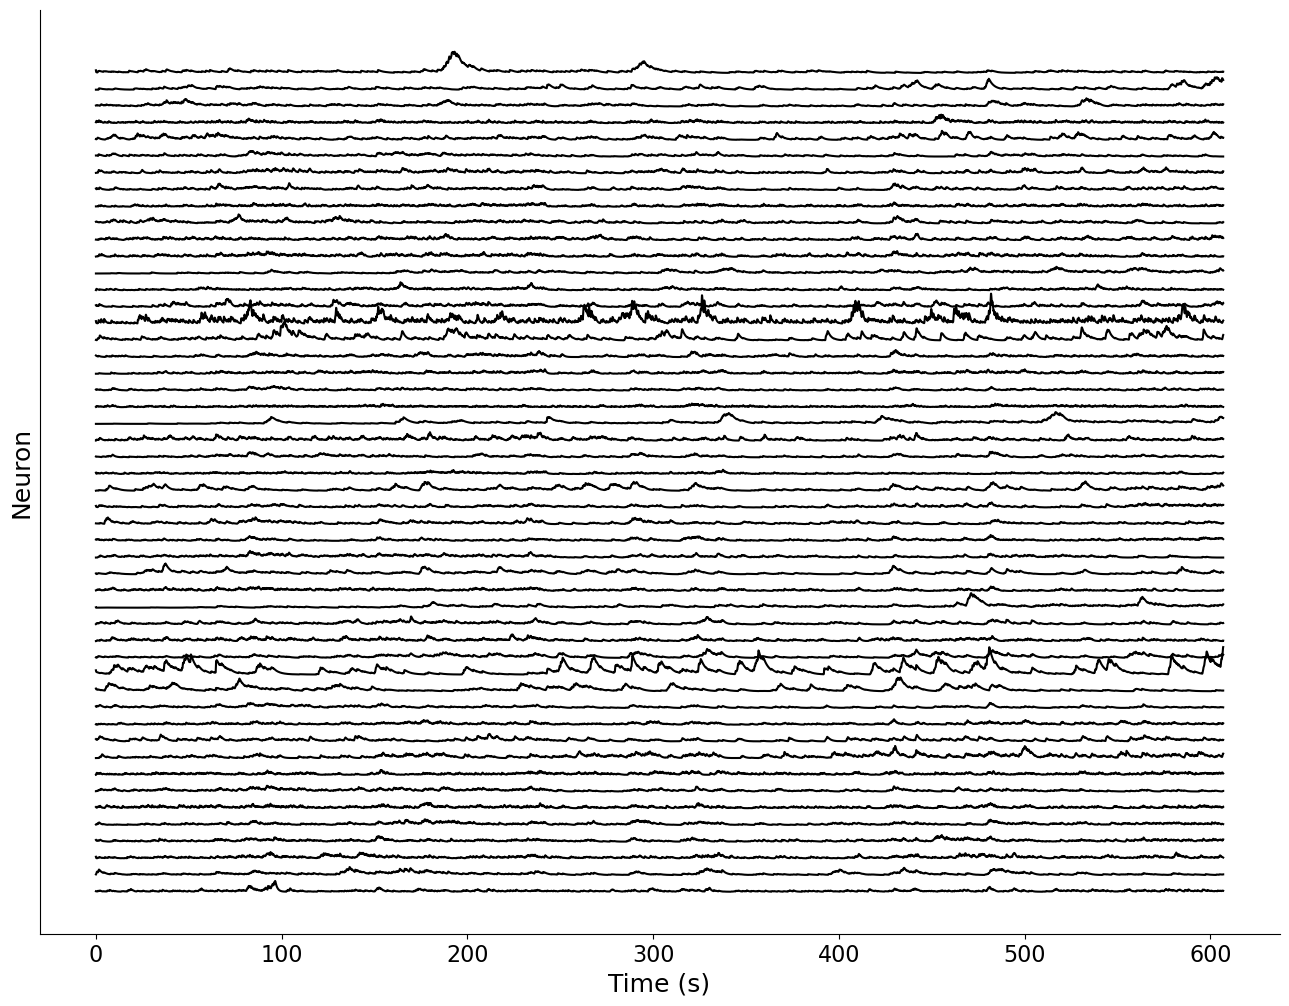

In [57]:
plt.figure(figsize=(16,12))
for i in range(50):
    plt.plot(data['time'], data['traces_denoised'][i] + i*1.5, color='k')

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Neuron', fontsize=18)
plt.yticks([])
plt.xticks(fontsize=16)

sb.despine()
#plt.savefig('plots/example_manyCalciumTraces.png', dpi=600)
plt.show()

### Firing rates

In [113]:
time_window = 0.4  # s
avg_data = average_spikes(data=data, window=time_window)

In [114]:
avg_data['avg_spikes'].shape

(2268, 1518)

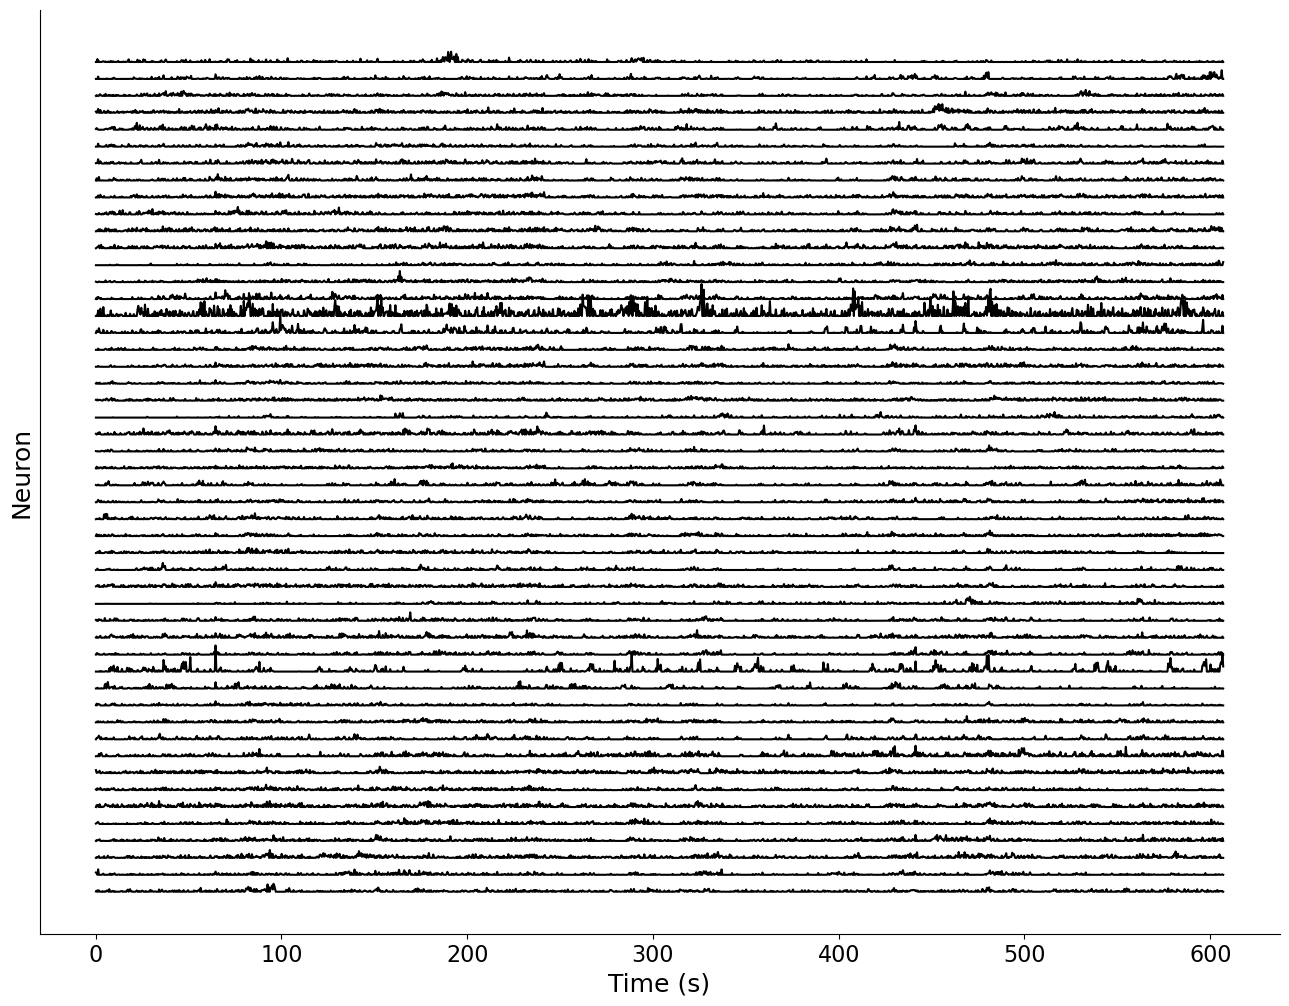

In [110]:
plt.figure(figsize=(16,12))
for i in range(50):
    plt.plot(avg_data['time'], avg_data['avg_spikes'][i] + i*.1, color='k')

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Neuron', fontsize=18)
plt.yticks([])
plt.xticks(fontsize=16)

sb.despine()
#plt.savefig('plots/example_manyCalciumTraces.png', dpi=600)
plt.show()

### Population dimensionality analysis

In [51]:
traces_reduced = PCA().fit(data['traces_denoised'].T)
variances = traces_reduced.explained_variance_ratio_

start_fit = 50
cutoff_fit = 500
x = np.arange(1, len(variances)+1)
y = variances
m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)

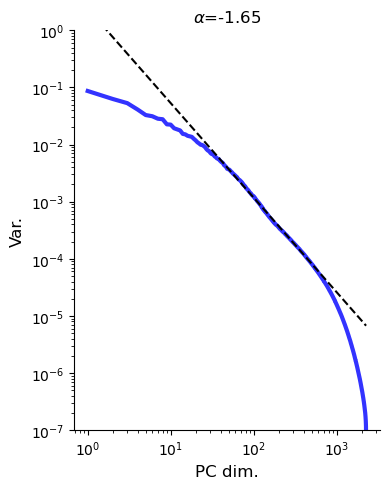

In [52]:
plt.figure(figsize=(4,5))

x = np.arange(1, len(variances)+1)
y = variances

plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)

x_fit = x
y_fit = np.exp(b) * x_fit**m
plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)

plt.xlabel('PC dim.', fontsize=12)
plt.ylabel('Var.', fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-7, 1e-0)

sb.despine()
plt.tight_layout()
plt.show()

### Pairwise correlation analysis

In [43]:
#correlations_ctx = compute_pairwise_correlations(data['traces_denoised'])
correlations_ctx = compute_pairwise_correlations(data['spikes'])

0/2268
1/2268
2/2268
3/2268
4/2268
5/2268
6/2268
7/2268
8/2268
9/2268
10/2268
11/2268
12/2268
13/2268
14/2268
15/2268
16/2268
17/2268
18/2268
19/2268
20/2268
21/2268
22/2268
23/2268
24/2268
25/2268
26/2268
27/2268
28/2268
29/2268
30/2268
31/2268
32/2268
33/2268
34/2268
35/2268
36/2268
37/2268
38/2268
39/2268
40/2268
41/2268
42/2268
43/2268
44/2268
45/2268
46/2268
47/2268
48/2268
49/2268
50/2268
51/2268
52/2268
53/2268
54/2268
55/2268
56/2268
57/2268
58/2268
59/2268
60/2268
61/2268
62/2268
63/2268
64/2268
65/2268
66/2268
67/2268
68/2268
69/2268
70/2268
71/2268
72/2268
73/2268
74/2268
75/2268
76/2268
77/2268
78/2268
79/2268
80/2268
81/2268
82/2268
83/2268
84/2268
85/2268
86/2268
87/2268
88/2268
89/2268
90/2268
91/2268
92/2268
93/2268
94/2268
95/2268
96/2268
97/2268
98/2268
99/2268
100/2268
101/2268
102/2268
103/2268
104/2268
105/2268
106/2268
107/2268
108/2268
109/2268
110/2268
111/2268
112/2268
113/2268
114/2268
115/2268
116/2268
117/2268
118/2268
119/2268
120/2268
121/2268
122/2268
123

923/2268
924/2268
925/2268
926/2268
927/2268
928/2268
929/2268
930/2268
931/2268
932/2268
933/2268
934/2268
935/2268
936/2268
937/2268
938/2268
939/2268
940/2268
941/2268
942/2268
943/2268
944/2268
945/2268
946/2268
947/2268
948/2268
949/2268
950/2268
951/2268
952/2268
953/2268
954/2268
955/2268
956/2268
957/2268
958/2268
959/2268
960/2268
961/2268
962/2268
963/2268
964/2268
965/2268
966/2268
967/2268
968/2268
969/2268
970/2268
971/2268
972/2268
973/2268
974/2268
975/2268
976/2268
977/2268
978/2268
979/2268
980/2268
981/2268
982/2268
983/2268
984/2268
985/2268
986/2268
987/2268
988/2268
989/2268
990/2268
991/2268
992/2268
993/2268
994/2268
995/2268
996/2268
997/2268
998/2268
999/2268
1000/2268
1001/2268
1002/2268
1003/2268
1004/2268
1005/2268
1006/2268
1007/2268
1008/2268
1009/2268
1010/2268
1011/2268
1012/2268
1013/2268
1014/2268
1015/2268
1016/2268
1017/2268
1018/2268
1019/2268
1020/2268
1021/2268
1022/2268
1023/2268
1024/2268
1025/2268
1026/2268
1027/2268
1028/2268
1029/2268
1030/22

1750/2268
1751/2268
1752/2268
1753/2268
1754/2268
1755/2268
1756/2268
1757/2268
1758/2268
1759/2268
1760/2268
1761/2268
1762/2268
1763/2268
1764/2268
1765/2268
1766/2268
1767/2268
1768/2268
1769/2268
1770/2268
1771/2268
1772/2268
1773/2268
1774/2268
1775/2268
1776/2268
1777/2268
1778/2268
1779/2268
1780/2268
1781/2268
1782/2268
1783/2268
1784/2268
1785/2268
1786/2268
1787/2268
1788/2268
1789/2268
1790/2268
1791/2268
1792/2268
1793/2268
1794/2268
1795/2268
1796/2268
1797/2268
1798/2268
1799/2268
1800/2268
1801/2268
1802/2268
1803/2268
1804/2268
1805/2268
1806/2268
1807/2268
1808/2268
1809/2268
1810/2268
1811/2268
1812/2268
1813/2268
1814/2268
1815/2268
1816/2268
1817/2268
1818/2268
1819/2268
1820/2268
1821/2268
1822/2268
1823/2268
1824/2268
1825/2268
1826/2268
1827/2268
1828/2268
1829/2268
1830/2268
1831/2268
1832/2268
1833/2268
1834/2268
1835/2268
1836/2268
1837/2268
1838/2268
1839/2268
1840/2268
1841/2268
1842/2268
1843/2268
1844/2268
1845/2268
1846/2268
1847/2268
1848/2268
1849/2268


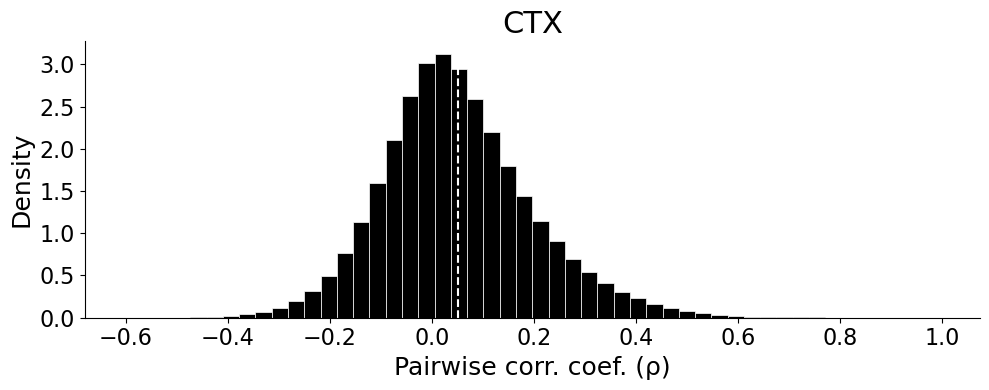

In [37]:
plt.figure(figsize=(10,4))

plt.hist(correlations_ctx, bins=50, color='k', alpha=1, edgecolor='white', linewidth=.5, density=True)

plt.axvline(x=np.mean(correlations_ctx), color='white', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.title('CTX', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-0.15, 0.5)

sb.despine()
plt.tight_layout()
#plt.savefig('plots/pairwiseCorrDistr_V1.png', dpi=600)
plt.show()

# Hippocampus CA1 (3p data) 

### Import and visualize data

In [9]:
mat_file_path = 'calcium_data/Alipasha/MB48_Hybrid_v2_00004_3pONLY_cnmf_results.mat' 
data_hpc = load_mat_v73(mat_file_path)
#print(data)

<KeysViewHDF5 ['#refs#', '#subsystem#', 'A_or', 'C_df', 'C_df_ave', 'C_df_dec', 'F0', 'S_dec', 'bl', 'center', 'frate', 'g', 'neuron_sn', 'options', 'time']>


In [35]:
print('Shapes: ', data_hpc['traces'].shape, data_hpc['traces_denoised'].shape, data_hpc['spikes'].shape, data_hpc['time'].shape, data_hpc['frate'].shape)

Shapes:  (127, 1676) (127, 1676) (127, 1676) (1676,) (1,)


In [34]:
print('Temporal resolution: ', 1/data_hpc['frate'][0], 'sec')

Temporal resolution:  0.3629500580720093 sec


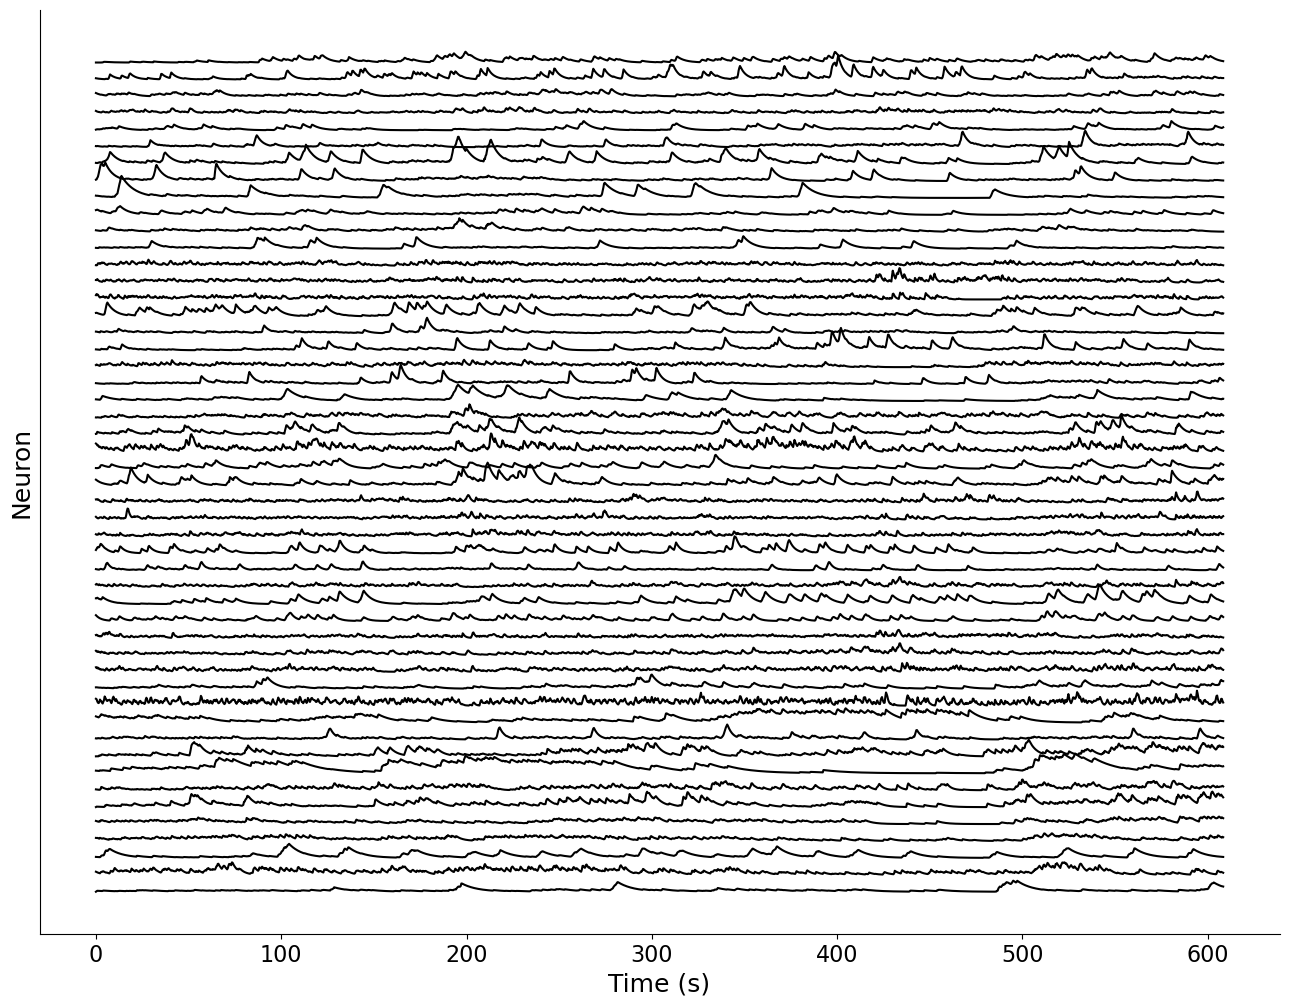

In [12]:
plt.figure(figsize=(16,12))
for i in range(50):
    plt.plot(data_hpc['time'], data_hpc['traces_denoised'][i] + i*1.5, color='k')

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Neuron', fontsize=18)
plt.yticks([])
plt.xticks(fontsize=16)

sb.despine()
#plt.savefig('plots/example_manyCalciumTraces.png', dpi=600)
plt.show()

### Population dimensionality analysis

In [13]:
traces_hpc_reduced = PCA().fit(data_hpc['traces_denoised'].T)
variances_hpc = traces_hpc_reduced.explained_variance_ratio_

start_fit = 10
cutoff_fit = 50
x = np.arange(1, len(variances)+1)
y = variances
m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)

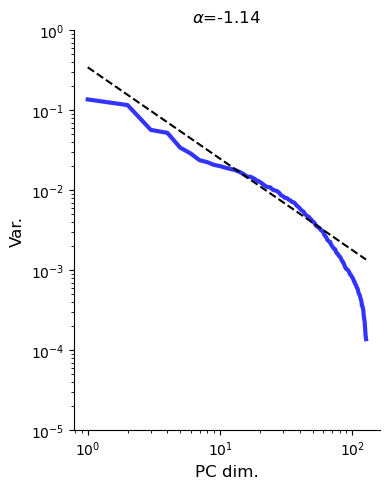

In [14]:
plt.figure(figsize=(4,5))

x = np.arange(1, len(variances_hpc)+1)
y = variances_hpc

plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)

x_fit = x
y_fit = np.exp(b) * x_fit**m
plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)

plt.xlabel('PC dim.', fontsize=12)
plt.ylabel('Var.', fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-5, 1e-0)

sb.despine()
plt.tight_layout()
plt.show()

### Pairwise correlation analysis

In [41]:
#correlations_hpc = compute_pairwise_correlations(data_hpc['traces_denoised'])
correlations_hpc = compute_pairwise_correlations(data_hpc['spikes'])

0/127
1/127
2/127
3/127
4/127
5/127
6/127
7/127
8/127
9/127
10/127
11/127
12/127
13/127
14/127
15/127
16/127
17/127
18/127
19/127
20/127
21/127
22/127
23/127
24/127
25/127
26/127
27/127
28/127
29/127
30/127
31/127
32/127
33/127
34/127
35/127
36/127
37/127
38/127
39/127
40/127
41/127
42/127
43/127
44/127
45/127
46/127
47/127
48/127
49/127
50/127
51/127
52/127
53/127
54/127
55/127
56/127
57/127
58/127
59/127
60/127
61/127
62/127
63/127
64/127
65/127
66/127
67/127
68/127
69/127
70/127
71/127
72/127
73/127
74/127
75/127
76/127
77/127
78/127
79/127
80/127
81/127
82/127
83/127
84/127
85/127
86/127
87/127
88/127
89/127
90/127
91/127
92/127
93/127
94/127
95/127
96/127
97/127
98/127
99/127
100/127
101/127
102/127
103/127
104/127
105/127
106/127
107/127
108/127
109/127
110/127
111/127
112/127
113/127
114/127
115/127
116/127
117/127
118/127
119/127
120/127
121/127
122/127
123/127
124/127
125/127
126/127


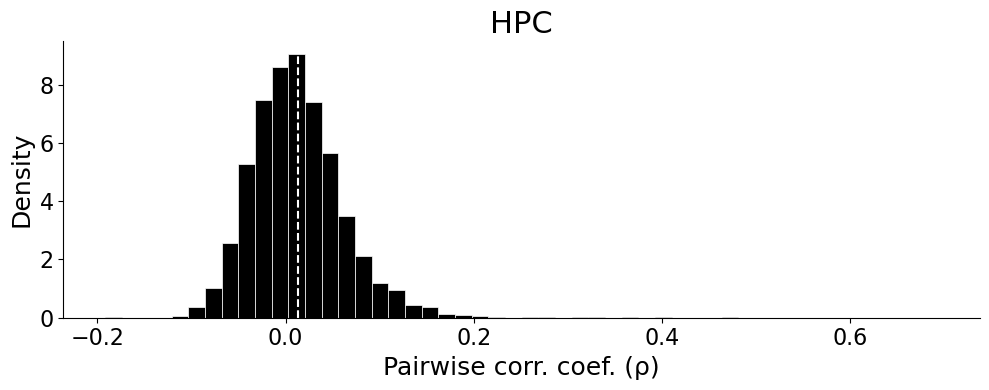

In [42]:
plt.figure(figsize=(10,4))

plt.hist(correlations_hpc, bins=50, color='k', alpha=1, edgecolor='white', linewidth=.5, density=True)

plt.axvline(x=np.mean(correlations_hpc), color='white', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.title('HPC', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-0.15, 0.5)

sb.despine()
plt.tight_layout()
#plt.savefig('plots/pairwiseCorrDistr_V1.png', dpi=600)
plt.show()

## Pairwise correlation comparison

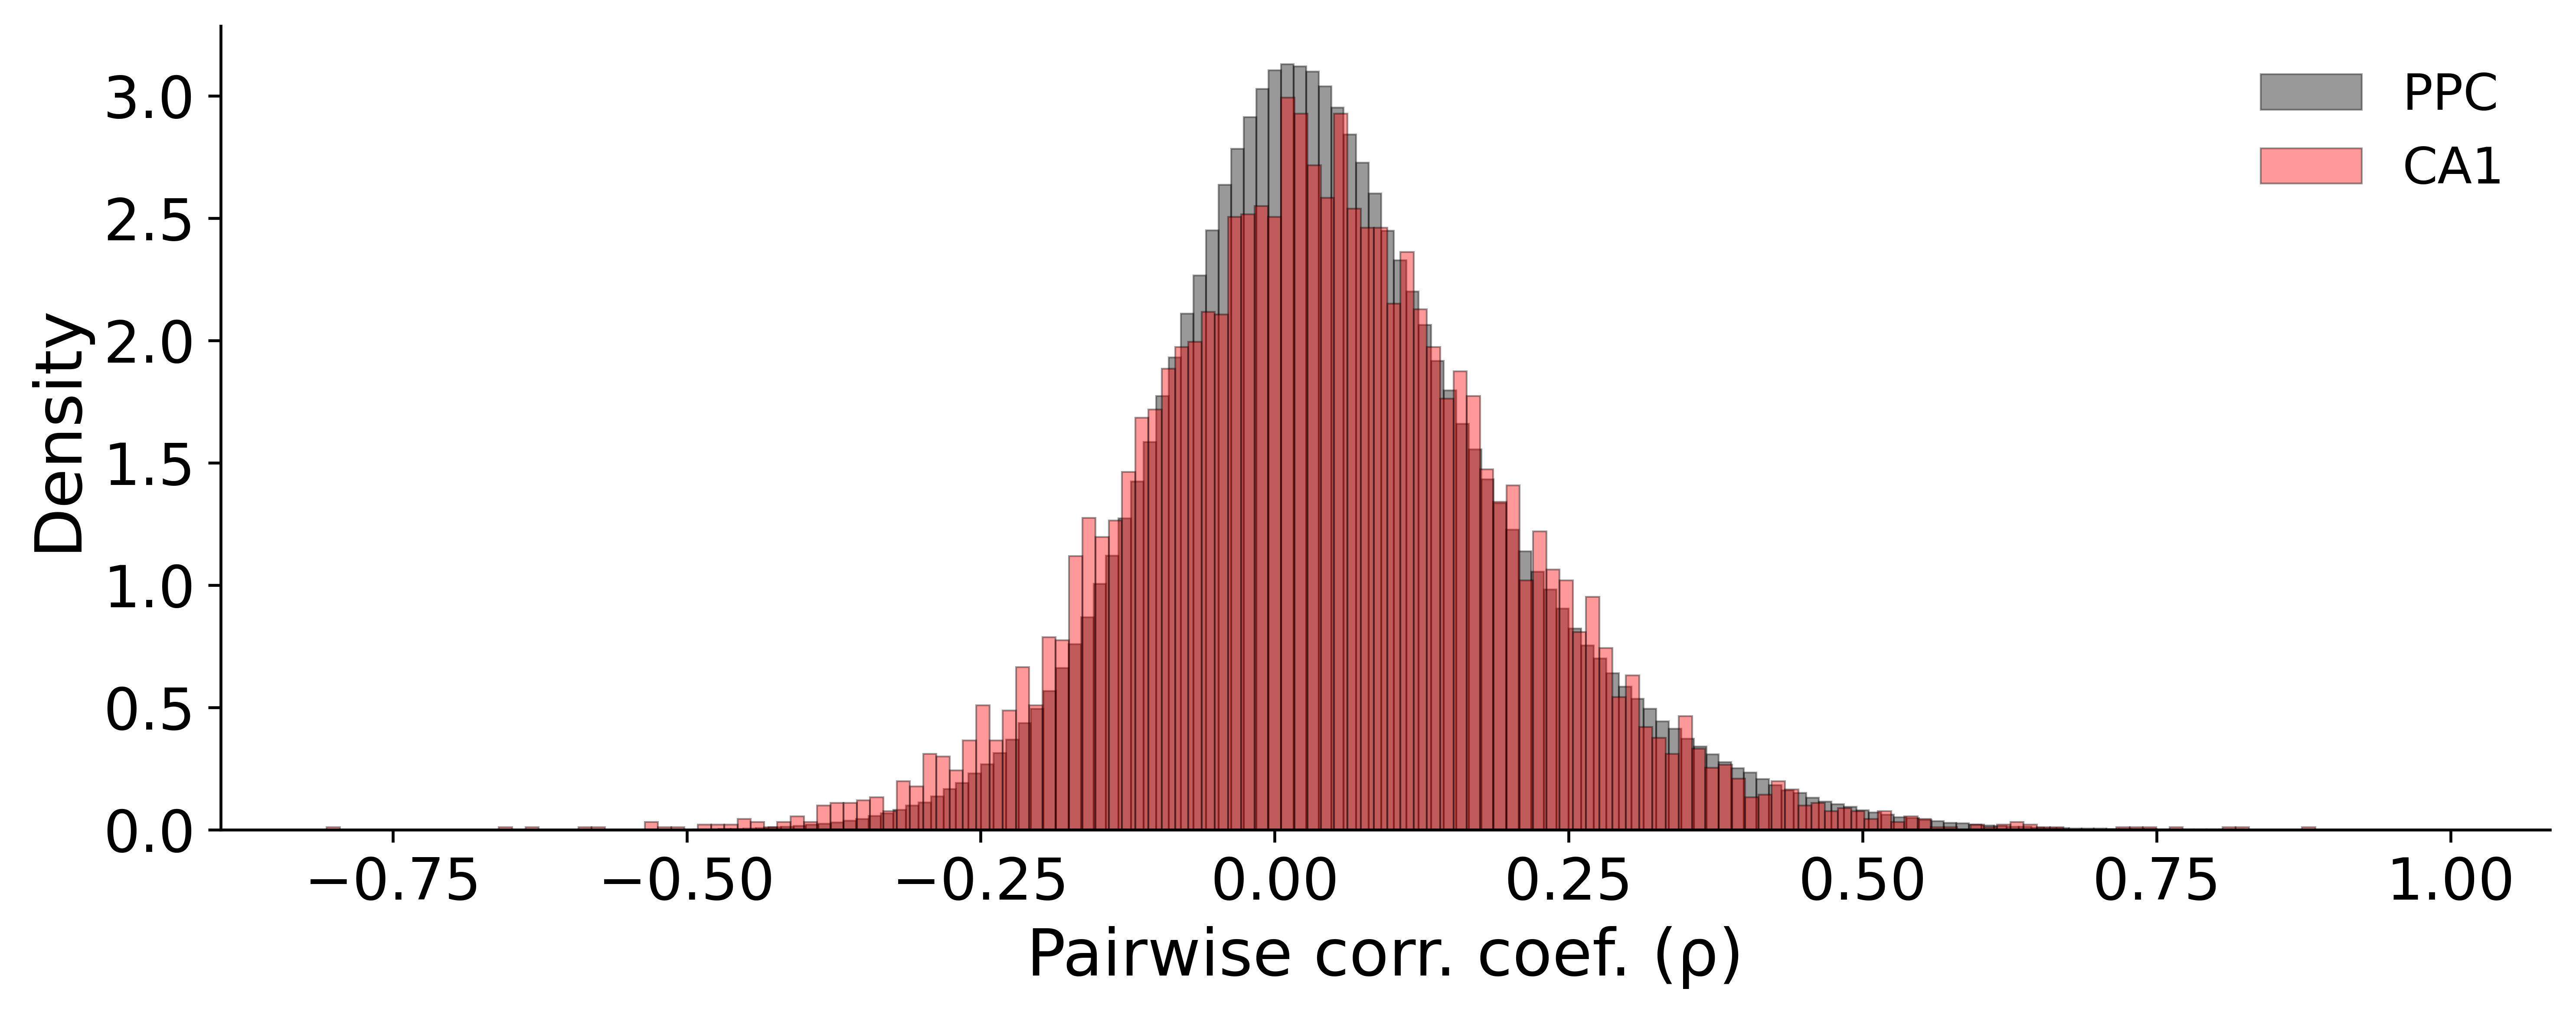

In [40]:
plt.figure(figsize=(10,4), dpi=600)

plt.hist(correlations_ctx, bins=150, color='k', alpha=.4, edgecolor='k', linewidth=.5, density=True, label='PPC')
plt.hist(correlations_hpc, bins=150, color='r', alpha=.4, edgecolor='k', linewidth=.5, density=True, label='CA1')

#plt.axvline(x=np.mean(correlations_v1), color='k', linestyle='--')
#plt.axvline(x=np.mean(correlations_ca1), color='r', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

#plt.title('V1', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-0.12, 0.12)

plt.legend(frameon=False, fontsize=14)

sb.despine()
plt.tight_layout()
#plt.savefig('plots/pairwiseCorrDistr_V1vsCA1.png', dpi=600)
plt.show()